# Tertiary Contacts

# Setup and Info

In [7]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
from rna_motif_library.plotting import (
    publication_style_ax,
    calculate_subplot_coordinates,
    merge_sequential_coords,
    draw_box_around_subplot,
)

PLOT_PATH = "../figures/plots"

In [8]:
def rename_motif_types(df):
    """Rename motif type values to more readable format.

    Args:
        df: DataFrame containing motif data

    Returns:
        DataFrame with renamed motif types
    """
    type_mapping = {
        "HELIX": "Helix",
        "SSTRAND": "Single Strand",
        "TWOWAY": "Two-way",
        "NWAY": "N-way",
        "HAIRPIN": "Hairpin",
    }

    df["motif_1_type"] = df["motif_1_type"].map(type_mapping)
    df["motif_2_type"] = df["motif_2_type"].map(type_mapping)
    return df

In [9]:
df = pd.read_json("../data/summaries/tertiary_contacts/unique_tertiary_contacts.json")
# Remove rows where either mtype_1 or mtype_2 is "UNKNOWN"
df = df[(df["motif_1_type"] != "UNKNOWN") & (df["motif_2_type"] != "UNKNOWN")]
df = rename_motif_types(df)

In [29]:
df_trans = pd.read_json(
    "../data/summaries/tertiary_contacts/tertiary_contacts_w_transient.json"
)
df_trans["num_res_1"] = df_trans["motif_1_res"].apply(len)
df_trans["num_res_2"] = df_trans["motif_2_res"].apply(len)

In [11]:
df_pdb_info = pd.read_json("../data/summaries/pdb_info.json")

In [12]:
df = df.merge(df_pdb_info, on="pdb_id", how="left")

In [13]:
len(df)

21241

## What are the columns?

In [30]:
df_trans.iloc[0]

pdb_id                                                                   8IFE
motif_1_id                                    HAIRPIN-11-CCUCUCCAGUCCG-8IFE-1
motif_2_id                        NWAY-4-3-3-2-GGAGCG-CUCCC-GGGCC-GCGC-8IFE-1
motif_1_type                                                          HAIRPIN
motif_2_type                                                             NWAY
motif_1_size                                                               11
motif_2_size                                                          4-3-3-2
m_sequence_1                                                    CCUCUCCAGUCCG
m_sequence_2                                          GGAGCG-CUCCC-GGGCC-GCGC
motif_1_res                              [1A-C-1439-, 1A-U-1440-, 1A-C-1441-]
motif_2_res                                          [1A-A-1270-, 1A-G-1269-]
num_hbonds                                                                  5
num_basepairs                                                   

In [14]:
df.iloc[0]

pdb_id                                                                         8Z1P
motif_1_id                                               HAIRPIN-7-GUUCAAAUC-8Z1P-1
motif_2_id                                              HAIRPIN-8-CAGUGGUGAG-8Z1P-1
motif_1_type                                                                Hairpin
motif_2_type                                                                Hairpin
motif_1_size                                                                      7
motif_2_size                                                                      8
m_sequence_1                                                              GUUCAAAUC
m_sequence_2                                                             CAGUGGUGAG
motif_1_res                       [B-C-56-, B-A-58-, B-U-55-, B-U-60-, B-A-57-, ...
motif_2_res                                             [B-G-19-, B-G-18-, B-G-15-]
num_hbonds                                                                  

# Statistics for tertiary contacts

In [26]:
len(df_trans)

68788

In [32]:
df_sub = df_trans.query("num_hbonds < 3")
print(len(df_sub))

37988


In [24]:
df_trans["num_hbonds"].sum()

220023

In [33]:
len(df)

21241

In [ ]:
len(df.query("is_isolatable == True"))

1039

In [ ]:
# Calculate the cumulative percent of rows for each num_hbonds value
hbonds_counts = df["num_hbonds"].value_counts().sort_index()
hbonds_cum_percent = hbonds_counts.cumsum() / len(df) * 100
print(hbonds_cum_percent)

num_hbonds
3      18.982157
4      38.835271
5      55.463490
6      67.040158
7      75.561414
8      81.794642
9      86.309496
10     89.675627
11     91.874206
12     93.343063
13     94.435290
14     95.362742
15     96.158373
16     96.930465
17     97.589567
18     98.102726
19     98.672379
20     98.983099
21     99.213785
22     99.397392
23     99.524504
24     99.642201
25     99.731651
26     99.764606
27     99.811685
28     99.835224
29     99.868179
30     99.896427
31     99.905842
32     99.943505
34     99.962337
35     99.967045
36     99.971753
37     99.981168
38     99.985876
43     99.990584
44     99.995292
86    100.000000
Name: count, dtype: float64


In [59]:
len(df.query("is_isolatable == True"))

1039

In [36]:
df.query("is_isolatable == True")[["motif_1_type", "motif_2_type"]].value_counts()

motif_1_type   motif_2_type 
Single Strand  Single Strand    819
Hairpin        Hairpin           63
               Single Strand     50
               Helix             44
               Two-way           28
Helix          Single Strand     16
               Two-way            8
               Helix              7
Two-way        Two-way            2
Hairpin        N-way              1
Single Strand  Two-way            1
Name: count, dtype: int64

# Plots

## Figure 2a: Motif type interactions

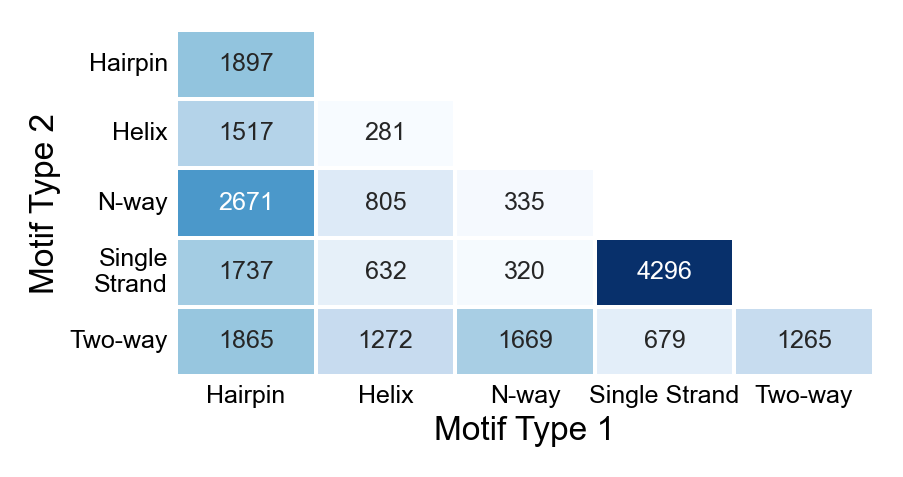

In [15]:
def figure_2a(df, ax):
    """Create heatmap showing motif type interactions.

    Args:
        df: DataFrame containing motif data with motif_1_type and motif_2_type columns
        ax: matplotlib axes object to plot on

    Returns:
        ax: matplotlib axes object with heatmap
    """
    # Create pivot table of counts
    pivot = pd.crosstab(df["motif_2_type"], df["motif_1_type"])

    # Create heatmap
    ax = sns.heatmap(
        pivot,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        ax=ax,
        mask=pivot == 0,  # Hide cells with value 0
        linewidths=0.5,  # Add small space between boxes
        linecolor="white",  # White lines for subtle separation
    )
    # Get current tick labels and modify "Single Strand" to "Single\nStrand"
    x_labels = [label.get_text() for label in ax.get_xticklabels()]
    y_labels = [label.get_text() for label in ax.get_yticklabels()]

    # Replace "Single Strand" with "Single\nStrand" in both x and y labels
    x_labels = [label.replace("Single Strand", "Single\nStrand") for label in x_labels]
    y_labels = [label.replace("Single Strand", "Single\nStrand") for label in y_labels]

    # Set the modified labels
    ax.set_yticklabels(y_labels)
    # Customize plot
    ax.tick_params(axis="x", rotation=0)
    ax.tick_params(axis="y", rotation=0)
    ax.set_xlabel("Motif Type 1", labelpad=2)
    ax.set_ylabel("Motif Type 2", labelpad=2)
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)
    ax.tick_params(width=0, size=0, pad=2)

    return ax


# Call the function
fig, ax = plt.subplots(figsize=(3.0, 1.5), dpi=300)
ax = figure_2a(df, ax)

## Figure 2b: Number of H-Bonds

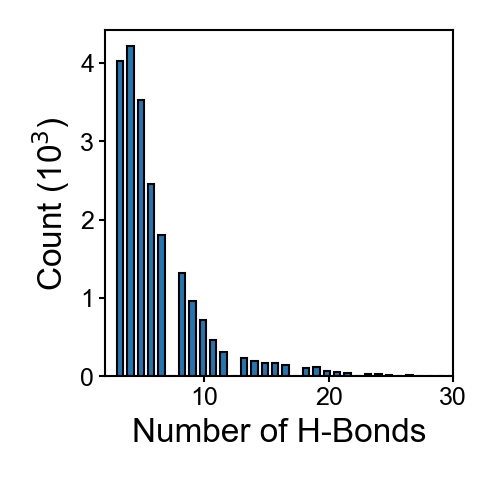

In [16]:
def figure_2b(df, ax):
    """Create histogram of number of H-bonds for tertiary contacts.

    Args:
        df: DataFrame containing tertiary contact data
        ax: matplotlib axis to plot on

    Returns:
        matplotlib axis with plot
    """
    ax.hist(df["num_hbonds"], bins=100, edgecolor="black", width=0.5, linewidth=0.5)
    ax.set_xlim(2, 30)
    ax.set_yticks([0, 1000, 2000, 3000, 4000])
    ax.set_yticklabels(["0", "1", "2", "3", "4"])
    ax.set_ylabel("Count (10$^3$)", labelpad=2)
    ax.set_xlabel("Number of H-Bonds", labelpad=2)
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)

    return ax


# Call the function
fig, ax = plt.subplots(figsize=(1.5, 1.5), dpi=300)
ax = figure_2b(df, ax)

## Figure 2c: Number of WC Pairs


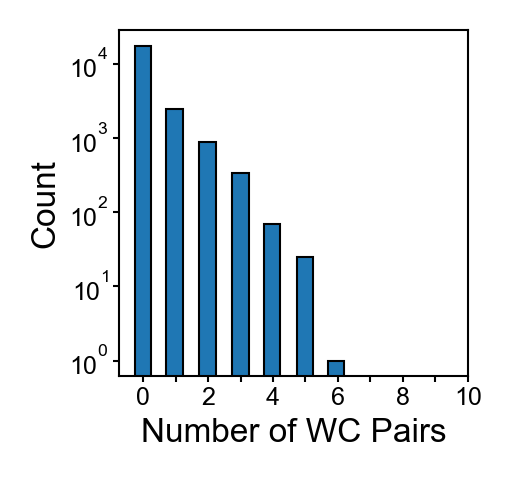

In [17]:
def figure_2c(df, ax):
    """Create histogram of number of WC pairs for tertiary contacts.

    Args:
        df: DataFrame containing tertiary contact data
        ax: matplotlib axis to plot on

    Returns:
        matplotlib axis with plot
    """
    ax.hist(df["num_wc_pairs"], bins=100, edgecolor="black", width=0.5, linewidth=0.5)
    ax.set_xlim(-0.5, 10)
    ax.set_xticks([x + 0.25 for x in range(11)])
    labels = [str(x) if i % 2 == 0 else "" for i, x in enumerate(range(0, 11))]
    ax.set_xticklabels(labels)
    ax.set_yscale("log")
    ax.set_yticks([1, 10, 100, 1000, 10000])
    ax.set_xlabel("Number of WC Pairs", labelpad=2)
    ax.set_ylabel("Count", labelpad=2)
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)
    return ax


# Call the function
fig, ax = plt.subplots(figsize=(1.5, 1.5), dpi=300)
ax = figure_2c(df, ax)

## Figure 2d: Number of Basepairs

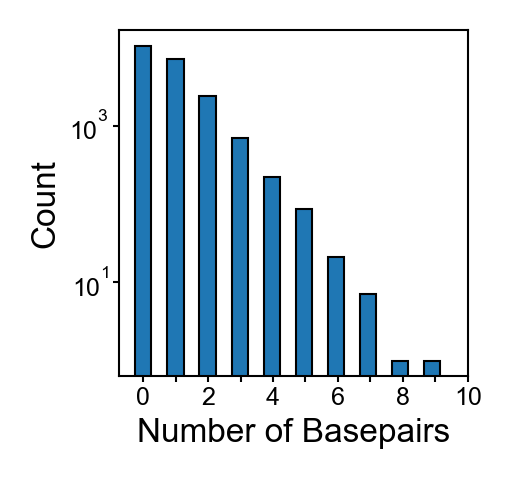

In [18]:
def figure_2d(df, ax):
    """Create histogram of number of basepairs for tertiary contacts.

    Args:
        df: DataFrame containing tertiary contact data
        ax: matplotlib axis to plot on

    Returns:
        matplotlib axis with plot
    """
    ax.hist(df["num_basepairs"], bins=100, edgecolor="black", width=0.5, linewidth=0.5)
    ax.set_xlim(-0.5, 10)
    ax.set_xticks([x + 0.25 for x in range(11)])
    labels = [str(x) if i % 2 == 0 else "" for i, x in enumerate(range(0, 11))]
    ax.set_xticklabels(labels)
    ax.set_yscale("log")
    ax.set_xlabel("Number of Basepairs", labelpad=2)
    ax.set_ylabel("Count", labelpad=2)
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)
    return ax


# Call the function
fig, ax = plt.subplots(figsize=(1.5, 1.5), dpi=300)
ax = figure_2d(df, ax)

In [19]:
df_sub = df[df["num_basepairs"] > 0]
df_sub.sort_values("num_basepairs", ascending=False, inplace=True)
df_sub[["motif_1_id", "motif_2_id", "num_basepairs"]].head(10)

/var/folders/lg/b_1r07zd7174kpbyfysdr7p0dxd870/T/ipykernel_40459/748776730.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.sort_values("num_basepairs", ascending=False, inplace=True)


,motif_1_id,motif_2_id,num_basepairs
12293,HAIRPIN-38-AGAUAAAAAAUCAAUGUCUUCGGACUCUUUGAUGA...,NWAY-52-6-5-4-AUAGAAUAGGACGUUUGGUUCUAUUUUGUUGG...,9
7247,SSTRAND-19-GACCCAUCCAUCCUCCCAC-8OVA-1,SSTRAND-26-UGUGAGUUCGGCGCAUUAAAGCAAAA-8OVA-1,8
2934,HELIX-10-AAAAGCAAAX-UUUUGCUUUU-4PLX-1,SSTRAND-10-UUUUUCUUUU-4PLX-1,7
2935,HELIX-10-AAAAGCAAAX-UUUUGCUUUU-4PLX-2,SSTRAND-11-GUUUUUCUUUU-4PLX-1,7
2936,HELIX-11-AAAAAGCAAAX-UUUUGCUUUUU-4PLX-1,SSTRAND-16-XGAAGGUUUUUCUUUU-4PLX-1,7
9202,HAIRPIN-14-GAAACCGCCGAUAUGC-4UYK-1,HAIRPIN-9-GGUUCGGCGUC-4UYK-1,7
19659,HAIRPIN-16-GACGAGGUGCGCCGUACC-5NWQ-1,SSTRAND-17-UCAGGACAAGACGGXGC-5NWQ-1,7
18094,HAIRPIN-16-GACGAGGUGCGCCGUACC-5NZ6-1,SSTRAND-17-UCACGACAAGACGGXGC-5NZ6-1,7
9188,SSTRAND-22-GACAGGCAAAAAAAAAAAAAAA-9G6K-1,SSTRAND-58-UUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUU...,7
19658,SSTRAND-21-GUAAGAGCCUAGCAUGUAGAA-6ZYM-1,SSTRAND-29-AUAUACUAAAAUUGGAACGAUACAGAGAA-6ZYM-1,6


## Figure 2e: Number of Tertiary Contacts

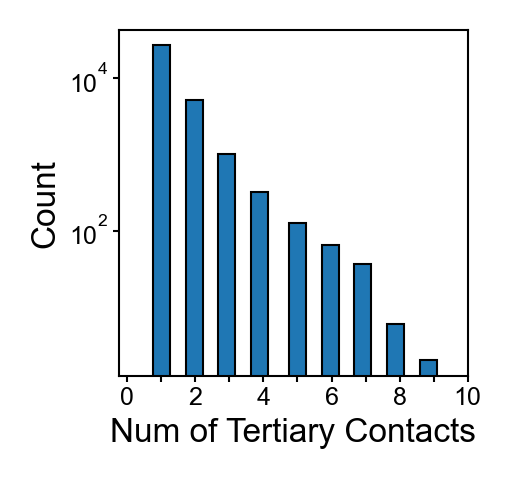

Total unique motifs: 33261
Most frequent motif appears 9 times
Average motif frequency: 1.28


In [20]:
def figure_2e(df, ax):
    """Create histogram of number of external H-bonds for tertiary contacts.

    Args:
        df: DataFrame containing tertiary contact data
        ax: matplotlib axis to plot on

    Returns:
        matplotlib axis with plot
    """
    # Combine motif_1_id and motif_2_id to get all motif occurrences
    all_motifs = pd.concat([df["motif_1_id"], df["motif_2_id"]])

    # Count frequency of each motif
    motif_counts = all_motifs.value_counts()

    # Create histogram of motif frequencies
    ax.hist(motif_counts.values, bins=50, edgecolor="black", width=0.5, linewidth=0.5)
    ax.set_yscale("log")
    ax.set_xlabel("Num of Tertiary Contacts", labelpad=2)
    ax.set_ylabel("Count", labelpad=2)
    ax.set_xlim(0, 10)
    ax.set_xticks([x + 0.25 for x in range(11)])
    labels = [str(x) if i % 2 == 0 else "" for i, x in enumerate(range(0, 11))]
    ax.set_xticklabels(labels)
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)

    return ax


# Create the plot
fig, ax = plt.subplots(figsize=(1.5, 1.5), dpi=300)
ax = figure_2e(df, ax)
plt.show()

# Print some statistics
all_motifs = pd.concat([df["motif_1_id"], df["motif_2_id"]])
motif_counts = all_motifs.value_counts()
print(f"Total unique motifs: {len(motif_counts)}")
print(f"Most frequent motif appears {motif_counts.iloc[0]} times")
print(f"Average motif frequency: {motif_counts.mean():.2f}")

In [ ]:
# Create a cumulative table for how many motifs appear 1, 2, ... times
motif_freq = motif_counts.value_counts().sort_index()
cumulative = motif_freq.cumsum()
cum_table = pd.DataFrame(
    {
        "num_appearances": motif_freq.index,
        "num_motifs": motif_freq.values,
        "cumulative_num_motifs": cumulative.values,
    }
)
print(cum_table)

   num_appearances  num_motifs  cumulative_num_motifs
0                1       26535                  26535
1                2        5179                  31714
2                3         997                  32711
3                4         315                  33026
4                5         126                  33152
5                6          65                  33217
6                7          36                  33253
7                8           6                  33259
8                9           2                  33261


## Figure 2f: Number of External H-Bonds

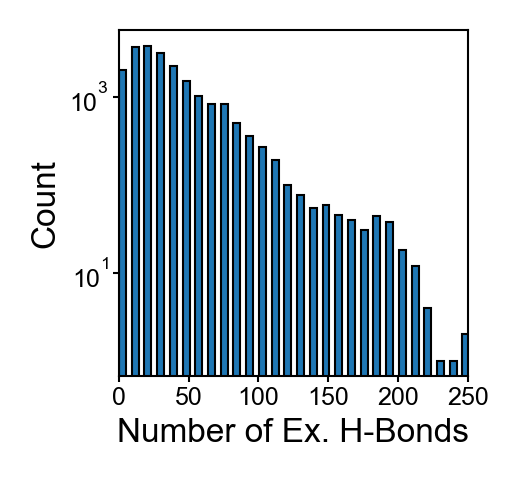

In [56]:
def figure_2f(df, ax):
    """Create histogram of number of external H-bonds for tertiary contacts.

    Args:
        df: DataFrame containing tertiary contact data
        ax: matplotlib axis to plot on

    Returns:
        matplotlib axis with plot
    """
    ax.hist(
        df["num_external_hbonds"], bins=50, edgecolor="black", linewidth=0.5, width=5
    )
    ax.set_xlim(0, 250)
    ax.set_xticks(np.arange(0, 300, 50))
    ax.set_yscale("log")
    ax.set_xlabel("Number of Ex. H-Bonds", labelpad=2)
    ax.set_ylabel("Count", labelpad=2)
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)

    return ax


# Call the function
fig, ax = plt.subplots(figsize=(1.5, 1.5), dpi=300)
ax = figure_2f(df, ax)

In [58]:
df.sort_values(by="num_external_hbonds", ascending=False).iloc[-2000]

pdb_id                                                                         5UQ7
motif_1_id                                                HAIRPIN-6-CGUAAUAG-5UQ7-1
motif_2_id                                             HAIRPIN-9-CUUAGAAGCAG-5UQ7-1
motif_1_type                                                                Hairpin
motif_2_type                                                                Hairpin
motif_1_size                                                                      6
motif_2_size                                                                      9
m_sequence_1                                                               CGUAAUAG
m_sequence_2                                                            CUUAGAAGCAG
motif_1_res                       [A-A-1098-, A-A-1095-, A-G-1093-, A-U-1097-, A...
motif_2_res                       [A-G-1071-, A-G-1068-, A-C-1072-, A-A-1070-, A...
num_hbonds                                                                  

## Figure 2g: Number of external basepairs

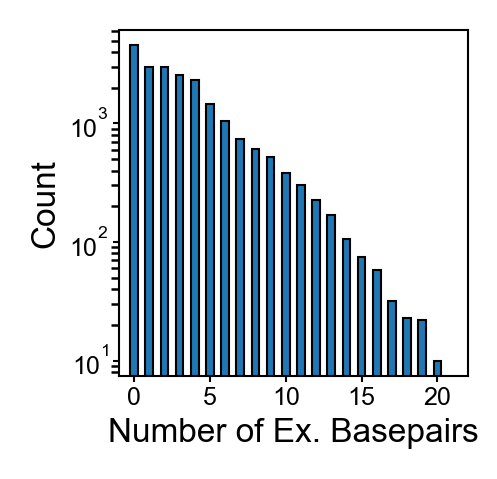

In [22]:
def figure_2g(df, ax):
    """Create histogram of number of external basepairs for tertiary contacts.

    Args:
        df: DataFrame containing tertiary contact data
        ax: matplotlib axis to plot on

    Returns:
        matplotlib axis with plot
    """
    # Count occurrences of each value from 0 to 10
    counts = df["num_external_basepairs"].value_counts().sort_index()

    # Create bars for values 0-10, filling in 0 for missing values
    x_positions = np.arange(21)  # 0 to 20
    bar_heights = [counts.get(i, 0) for i in range(21)]

    ax.bar(x_positions, bar_heights, edgecolor="black", linewidth=0.5, width=0.5)
    ax.set_xlim(-1, 22)
    ax.set_xticks(np.arange(0, 21, 5))  # Show ticks every 5
    ax.set_yscale("log")
    ax.set_xlabel("Number of Ex. Basepairs", labelpad=2)
    ax.set_ylabel("Count", labelpad=2)
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)
    return ax


# Call the function
fig, ax = plt.subplots(figsize=(1.5, 1.5), dpi=300)
ax = figure_2g(df, ax)

## Full Figure

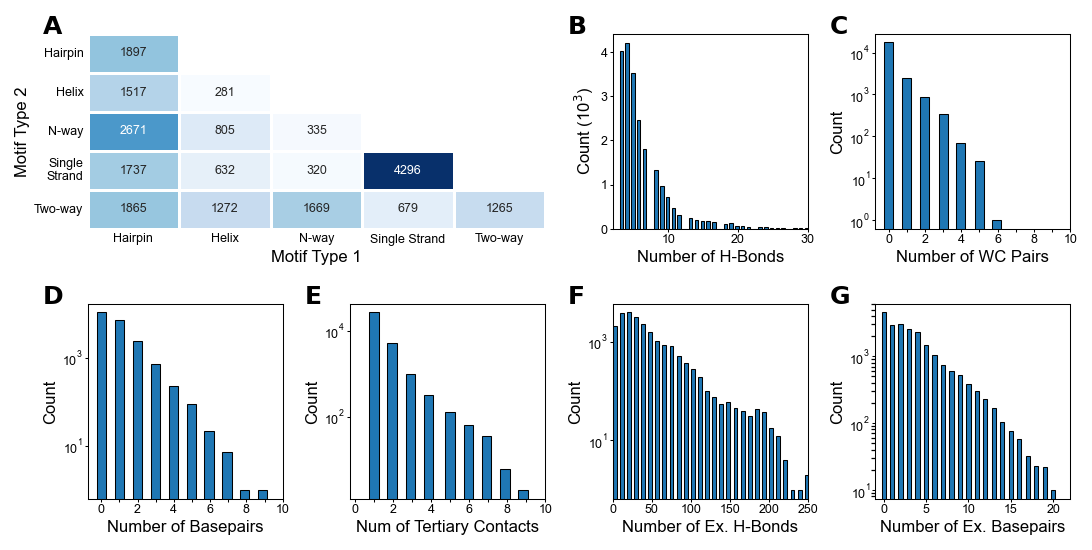

In [23]:
fig_size = (7, 4)
layout = (2, 4)
subplot_size = (1.3, 1.3)  # Each subplot is 4" x 3"
spacing = {
    "hspace": 0.45,  # horizontal spacing in inches
    "wspace": 0.50,  # vertical spacing in inches
    "margins": {"left": 0.30, "right": 0.0, "top": 0.0, "bottom": 0.70},
}

coords_list = calculate_subplot_coordinates(fig_size, layout, subplot_size, spacing)
coords_list = merge_sequential_coords(coords_list, 0, 1)

fig = plt.figure(figsize=fig_size, dpi=150)
# Create subplots
ax1 = fig.add_axes(coords_list[0])
figure_2a(df, ax1)

ax2 = fig.add_axes(coords_list[1])
figure_2b(df, ax2)

ax3 = fig.add_axes(coords_list[2])
figure_2c(df, ax3)

ax4 = fig.add_axes(coords_list[3])
figure_2d(df, ax4)

ax5 = fig.add_axes(coords_list[4])
figure_2e(df, ax5)

ax6 = fig.add_axes(coords_list[5])
figure_2f(df, ax6)

ax7 = fig.add_axes(coords_list[6])
figure_2g(df, ax7)


# add_text_inches(fig, fig_width, fig_height, 0.1, 0.1, "A", fontsize=12, weight="bold")
letters = ["A", "B", "C", "D", "E", "F", "G"]
for i, letter in enumerate(letters):
    fig.text(
        coords_list[i][0] - 0.3 / fig_size[0],
        coords_list[i][1] + 1.3 / fig_size[1],
        letter,
        fontsize=12,
        weight="bold",
    )

fig.savefig(os.path.join(PLOT_PATH, "Figure_2.png"), dpi=600)